In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
LOG_STD_MAX = 2
LOG_STD_MIN = -20

class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, max_agents, masked):
        super(MultiHeadAttention, self).__init__()
        assert model_dim % num_heads == 0

        self.num_heads = num_heads
        self.model_dim = model_dim
        self.split_head_dim = model_dim // num_heads
        self.masked = masked

        self.W_Q = nn.Linear(model_dim, model_dim)
        self.W_K = nn.Linear(model_dim, model_dim)
        self.W_V = nn.Linear(model_dim, model_dim)
        self.W_O = nn.Linear(model_dim, model_dim)

        if self.masked:
            self.register_buffer('tril', torch.tril(torch.ones(max_agents, max_agents)))

    def scaled_dot_product_attention(self, Q, K, V):
        attention_scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(self.split_head_dim)
        if self.masked:
            attention_scores = attention_scores.masked_fill(self.tril[:self.n_agents, :self.n_agents] == 0, float('-inf'))
        attention_probs = torch.softmax(attention_scores, dim=-1)
        output = torch.matmul(attention_probs, V)
        return output

    def split_heads(self, x):
        return x.view(self.bs, self.n_agents, self.num_heads, self.split_head_dim).transpose(1, 2)

    def combine_heads(self, x):
        return x.transpose(1, 2).contiguous().view(self.bs, self.n_agents, self.model_dim)

    def forward(self, Q, K, V):
        self.bs, self.n_agents, _ = Q.size()
        Q = self.split_heads(self.W_Q(Q))
        K = self.split_heads(self.W_K(K))
        V = self.split_heads(self.W_V(V))

        attn = self.scaled_dot_product_attention(Q, K, V)
        output = self.W_O(self.combine_heads(attn))
        return output

class FF_MLP(nn.Module):
    def __init__(self, model_dim, dim_ff):
        super(FF_MLP, self).__init__()
        self.fc1 = nn.Linear(model_dim, dim_ff)
        self.fc2 = nn.Linear(dim_ff, model_dim)

    def forward(self, x):
        return self.fc2(F.gelu(self.fc1(x)))

# Position Encoder for robotics should encode the ID of the robot (i,j)
# TODO: Change this function to capture the spatial arrangement of delta robots
class PositionalEncoder(nn.Module):
    def __init__(self, model_dim, max_seq_len):
        super(PositionalEncoder, self).__init__()
        pe = torch.zeros(max_seq_len, model_dim, requires_grad=False)
        pos = torch.arange(0, max_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * -(np.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class StateEncoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads, max_agents, dim_ff, dropout):
        super(StateEncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(model_dim, num_heads, max_agents, masked=False)
        self.feed_forward = FF_MLP(model_dim, dim_ff)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(model_dim)
        self.layer_norm2 = nn.LayerNorm(model_dim)

    def forward(self, x):
        x = self.layer_norm1(x)
        attn = self.self_attention(x, x, x)
        x = self.layer_norm2(x + self.dropout(attn))
        ff_embed = self.feed_forward(x)
        x = x + self.dropout(ff_embed)
        return x

class CriticDecoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads, max_agents, dim_ff, dropout):
        super(CriticDecoderLayer, self).__init__()
        self.cross_attention = MultiHeadAttention(model_dim, num_heads, max_agents, masked=False)
        self.feed_forward = FF_MLP(model_dim, dim_ff)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(model_dim)
        self.layer_norm2 = nn.LayerNorm(model_dim)

    def forward(self, x, decoder_output):
        x = self.layer_norm1(x)
        attn = self.cross_attention(x, decoder_output, decoder_output)
        x = self.layer_norm2(x + self.dropout(attn))
        ff_embed = self.feed_forward(x)
        x = x + self.dropout(ff_embed)
        return x

class ActorDecoderLayer(nn.Module):
    def __init__(self, model_dim, num_heads, max_agents, dim_ff, dropout):
        super(ActorDecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(model_dim, num_heads, max_agents, masked=True)
        self.cross_attention = MultiHeadAttention(model_dim, num_heads, max_agents, masked=True)
        self.feed_forward = FF_MLP(model_dim, dim_ff)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm1 = nn.LayerNorm(model_dim)
        self.layer_norm2 = nn.LayerNorm(model_dim)
        self.layer_norm3 = nn.LayerNorm(model_dim)

    def forward(self, x, encoder_output):
        x = self.layer_norm1(x)
        attn = self.self_attention(x, x, x)
        x = self.layer_norm2(x + self.dropout(attn))
        attn = self.cross_attention(x, encoder_output, encoder_output)
        x = self.layer_norm3(x + self.dropout(attn))
        ff_embed = self.feed_forward(x)
        x = x + self.dropout(ff_embed)
        return x

class StateEncoder(nn.Module):
    def __init__(self, model_dim, state_dim, num_heads, max_agents, dim_ff, dropout, n_layers, pos_enc):
        super(StateEncoder, self).__init__()
        self.state_embedding = nn.Linear(state_dim, model_dim)
        self.positional_encoding = pos_enc
        self.dropout = nn.Dropout(dropout)
        self.encoder_layers = nn.ModuleList([StateEncoderLayer(model_dim, num_heads, max_agents, dim_ff, dropout) for _ in range(n_layers)])

    def forward(self, states):
        """
        Input: states (bs, n_agents, state_dim)
        Output: state_enc (bs, n_agents, model_dim)
        """
        state_enc = self.dropout(self.positional_encoding(F.gelu(self.state_embedding(states))))
        for layer in self.encoder_layers:
            state_enc = layer(state_enc)
        return state_enc

class CriticDecoder(nn.Module):
    def __init__(self, model_dim, action_dim, num_heads, max_agents, dim_ff, dropout, n_layers, pos_enc):
        super(CriticDecoder, self).__init__()
        self.action_embedding = nn.Linear(action_dim, model_dim)
        self.positional_encoding = pos_enc
        self.dropout = nn.Dropout(dropout)

        self.decoder_layers = nn.ModuleList([CriticDecoderLayer(model_dim, num_heads, max_agents, dim_ff, dropout) for _ in range(n_layers)])
        self.critic_op_layer = nn.Linear(model_dim, 1)

    def forward(self, state_enc, actions):
        """
        Input: state_enc (bs, n_agents, model_dim)
               actions (bs, n_agents, action_dim)
        Output: q_value (bs, 1) --> Centralized Critic Q' = 1/N * ∑Q
        """
        act_enc = self.dropout(self.positional_encoding(F.gelu(self.action_embedding(actions))))
        for layer in self.decoder_layers:
            act_enc = layer(act_enc, state_enc)
        q_val = self.critic_op_layer(act_enc)
        return torch.mean(q_val, axis=1)

class ActorDecoder(nn.Module):
    def __init__(self, model_dim, action_dim, num_heads, max_agents, dim_ff, dropout, n_layers, pos_enc):
        super(ActorDecoder, self).__init__()
        self.action_embedding = nn.Linear(action_dim, model_dim) # Replace action embedding of Critic Decoder from this.
        self.positional_encoding = pos_enc
        self.dropout = nn.Dropout(dropout)

        self.decoder_layers = nn.ModuleList([ActorDecoderLayer(model_dim, num_heads, max_agents, dim_ff, dropout) for _ in range(n_layers)])
        self.actor_mu_layer = nn.Linear(model_dim, action_dim)
        self.actor_std_layer = nn.Linear(model_dim, action_dim)

    def forward(self, state_enc, actions):
        """
        Input: state_enc (bs, n_agents, model_dim)
               actions (bs, n_agents, action_dim)
        Output: decoder_output (bs, n_agents, model_dim)
        """
        act_enc = self.dropout(self.positional_encoding(F.gelu(self.action_embedding(actions))))
        for layer in self.decoder_layers:
            act_enc = layer(act_enc, state_enc)
        act_mean = self.actor_mu_layer(act_enc)
        act_std = self.actor_std_layer(act_enc)
        act_std = torch.clamp(act_std, LOG_STD_MIN, LOG_STD_MAX)
        act_std = torch.exp(act_std)
        return act_mean, act_std

class Transformer(nn.Module):
    def __init__(self, state_dim, action_dim, action_limit, model_dim, num_heads, dim_ff, num_layers, dropout, delta_array_size = (8,8)):
        super(Transformer, self).__init__()
        """
        For 2D planar manipulation:
            state_dim = 6: state, goal, pos of robot
            action_dim = 2: action of robot
        max_agents = delta_array_size[0] * delta_array_size[1]: Maximum number of agents in the environment
        model_dim: size of attn layers (model_dim % num_heads = 0)
        dim_ff: size of MLPs
        num_layers: number of layers in encoder and decoder
        """
        self.max_agents = delta_array_size[0] * delta_array_size[1]
        self.act_limit = action_limit
        self.action_dim = action_dim
        self.positional_encoding = PositionalEncoder(model_dim, self.max_agents)

        self.encoder = StateEncoder(model_dim, state_dim, num_heads, self.max_agents, dim_ff, dropout, num_layers['encoder'], self.positional_encoding)
        self.decoder_critic1 = CriticDecoder(model_dim, action_dim, num_heads, self.max_agents, dim_ff, dropout, num_layers['critic'], self.positional_encoding)
        self.decoder_critic2 = CriticDecoder(model_dim, action_dim, num_heads, self.max_agents, dim_ff, dropout, num_layers['critic'], self.positional_encoding)
        
        self.decoder_actor = ActorDecoder(model_dim, action_dim, num_heads, self.max_agents, dim_ff, dropout, num_layers['actor'], self.positional_encoding)

    def eval_actor(self, state_enc, actions):
        """
        Input: state_enc (bs, n_agents, model_dim)
        Output: actions (bs, n_agents, action_dim)
        """
        shifted_actions = torch.zeros((bs, n_agents, self.action_dim)).to(device)
        shifted_actions[:, 1:, :] = actions[:, :-1, :]  # Input actions go from 0 to A_n-1
        act_mean, act_std = self.decoder_actor(state_enc, shifted_actions)
        
        dist = torch.distributions.Normal(act_mean, act_std)
        entropy = dist.entropy()

        output_actions = dist.rsample()
        log_probs = dist.log_prob(output_actions).sum(axis=-1)
        log_probs -= (2*(np.log(2) - output_actions - F.softplus(-2*output_actions))).sum(axis=2)
        
        output_actions = torch.tanh(output_actions)
        output_actions = self.act_limit * output_actions # Output actions go from A_0 to A_n
        return output_actions, log_probs, entropy

    def get_actions(self, state_enc, deterministic=False):
        """ Returns actor actions, and their log probs. If deterministic=True, set action as the output of decoder. Else, sample from mean=dec output, std=exp(log_std) """
        bs, n_agents, _ = state_enc.size()
        shifted_actions = torch.zeros((bs, n_agents, self.action_dim)).to(device)
        output_actions = torch.zeros((bs, n_agents, self.action_dim)).to(device)
        output_action_log_probs = torch.zeros((bs, n_agents)).to(device)

        for i in range(n_agents):
            act_means, act_stds = self.decoder_actor(state_enc, shifted_actions)

            if deterministic:
                output_action = self.act_limit * torch.tanh(act_means[:, i, :])
                output_action_log_prob = 0
            else:
                dist = torch.distributions.Normal(act_means[:, i, :], act_stds[:, i, :])
                output_action = dist.rsample()

                output_action_log_prob = dist.log_prob(output_action).sum(axis=-1)
                output_action_log_prob -= (2*(np.log(2) - output_action - F.softplus(-2*output_action))).sum(axis=1)
                output_action = torch.tanh(output_action)
                output_action = self.act_limit * output_action

            output_actions[:, i, :] = output_action 
            output_action_log_probs[:, i] = output_action_log_prob
            if (i+1) < n_agents:
                shifted_actions[:, i+1, :] = output_action 
        return output_actions, output_action_log_probs

In [3]:
class MATAC:
    def __init__(self, env_dixt, hp_dict, logger_kwargs=dict(), train_or_test="train"):
        if train_or_test == "train":
            self.logger = EpochLogger(**logger_kwargs)
            self.logger.save_config(locals())

        self.train_or_test = train_or_test
        self.hp_dict = hp_dict
        self.env_dict = env_dict
        self.obs_dim = self.env_dict['observation_space']['dim']
        self.act_dim = self.env_dict['action_space']['dim']
        self.act_limit = self.env_dict['action_space']['high']

        # n_layers_dict={'encoder': 2, 'actor': 2, 'critic': 2}
        self.tf = Transformer(self.obs_dim, self.act_dim, self.act_limit, self.hp_dict["model_dim"], self.hp_dict["num_heads"], self.hp_dict["dim_ff"], self.hp_dict["n_layers_dict"], self.hp_dict["dropout"], self.hp_dict["delta_array_size"])
        self.tf_target = deepcopy(self.tf)

        self.tf = self.tf.to(device)
        self.tf_target = self.tf_target.to(device)
        # Freeze target networks with respect to optimizers (only update via polyak averaging)
        for p in self.tf_target.parameters():
            p.requires_grad = False

        self.ma_replay_buffer = MultiAgentReplayBuffer(obs_dim=self.obs_dim, act_dim=self.act_dim, size=hp_dict['replay_size'], max_agents=self.max_agents)

        # Count variables (protip: try to get a feel for how different size networks behave!)
        var_counts = tuple(core.count_vars(module) for module in [self.tf.encoder, self.tf.decoder_actor, self.tf.decoder_critic1, self.tf.decoder_critic2])
        if self.train_or_test == "train":
            self.logger.log('\nNumber of parameters: \t Encoder: %d, \t Actor Decoder: %d, \t Critic Decoder: %d\n'%var_counts)

        self.critic_params = itertools.chain(self.tf.encoder.parameters(), self.tf.decoder_critic1.parameters(), self.tf.decoder_critic2.parameters())
        self.optimizer_critic = Adam(self.critic_params, lr=hp_dict['q_lr'])
        self.optimizer_actor = Adam(self.tf.decoder_actor.parameters(), lr=hp_dict['pi_lr'])

        # Set up model saving
        if self.train_or_test == "train":
            self.logger.setup_pytorch_saver(self.tf)

    def compute_q_loss(self, s1, a, s2, r, d):
        q1 = self.tf.decoder_critic1(s1, a)
        q2 = self.tf.decoder_critic2(s1, a)
        
        with torch.no_grad():
            next_state_enc = self.tf.encoder(s2)
            next_actions, next_log_pi = self.tf.get_actions(next_state_enc)
            """ For now our problem is a single-step problem, so we don't need to compute the next_q values. 
            TODO: Investigate if we can improve something here later. e.g. take inspiration from PPO MAT code and see if I can include entropy and shiiz to add to the q_loss"""
            # next_q1 = self.tf_target.decoder_critic1(next_state_enc, next_actions)
            # next_q2 = self.tf_target.decoder_critic2(next_state_enc, next_actions)
            q_next = r # + self.hp_dict['gamma'] * (1 - d) * (torch.min(next_q1, next_q2) - self.hp_dict['alpha'] * next_log_pi)
        
        q_loss = F.mse_loss(q1, q_next) + F.mse_loss(q2, q_next)

        q_info = dict(Q1Vals=q1.detach().numpy(), Q2Vals=q2.detach().numpy())
        return q_loss, q_info

    def compute_pi_loss(self, s1):
        state_enc = self.tf.encoder(s1)
        actions, log_pi = self.tf.get_actions(state_enc)
        
        q1_pi = self.tf.decoder_critic1(state_enc, actions)
        q2_pi = self.tf.decoder_critic2(state_enc, actions)
        q_pi = torch.min(q1_pi, q2_pi)
        pi_loss = (self.hp_dict['alpha'] * log_pi - q_pi).mean()

        pi_info = dict(LogPi=logp_pi.detach().numpy())
        return pi_loss, pi_info

    def update(self, batch_size):
        data = self.ma_replay_buffer.sample_batch(batch_size)
        states, actions, rews, new_states, dones = data['obs'].to(device), data['act'].to(device), data['rew'].to(device), data['obs2'].to(device), data['done'].to(device)

        # Critic Update
        self.optimizer_critic.zero_grad()
        q_loss, q_info = self.compute_q_loss(states, actions, new_states, rews, dones)
        q_loss.backward()
        self.optimizer_critic.step()
        
        # Set action embeddings of critic to be the same as actor so there is consistency.
        self.tf.decoder_critic1.action_embedding.weight.data = self.tf.decoder_actor.action_embedding.weight.data.clone()
        self.tf.decoder_critic1.action_embedding.bias.data = self.tf.decoder_actor.action_embedding.bias.data.clone()
        self.tf.decoder_critic2.action_embedding.weight.data = self.tf.decoder_actor.action_embedding.weight.data.clone()
        self.tf.decoder_critic2.action_embedding.bias.data = self.tf.decoder_actor.action_embedding.bias.data.clone()

        logger.store(LossQ=loss_q.item(), **q_info)

        # Actor Update
        for p in self.critic_params:
            p.requires_grad = False
        self.optimizer_actor.zero_grad()
        pi_loss, pi_info = self.compute_pi_loss(states)
        pi_loss.backward()
        self.optimizer_actor.step()
        for p in self.critic_params:
            p.requires_grad = True

        logger.store(LossPi=loss_pi.item(), **pi_info)

        # Target Update
        with torch.no_grad():
            for p, p_target in zip(self.tf.parameters(), self.tf_target.parameters()):
                p_target.data.mul_(self.hp_dict['tau'])
                p_target.data.add_((1 - self.hp_dict['tau']) * p.data)
    
    def get_actions(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32).to(device)
        obs = obs.unsqueeze(0)
        state_enc = self.tf.encoder(obs)
        actions, _ = self.tf.get_actions(state_enc, deterministic=deterministic)
        return actions.detach().cpu().numpy()
        
    def load_saved_policy(self, path='./data/rl_data/backup/matsac_expt_grasp/pyt_save/model.pt'):
        self.tf.load_state_dict(torch.load(path))
        self.tf_target = deepcopy(self.tf)

In [7]:
tf = Transformer(state_dim=6, action_dim=2, action_limit=3, model_dim=128, num_heads=4, dim_ff=256, num_layers={'encoder': 2, 'actor': 2, 'critic': 2}, dropout=0.1, delta_array_size=(8,8))
tf.to(device)

bs = 32
n_agents = 10
state = torch.randn(bs, n_agents, 6).to(device)
state_enc = tf.encoder(state)
print(state_enc.shape)
output_actions, op_act_log_probs = tf.get_actions(state_enc, deterministic=False)
print(output_actions.shape, op_act_log_probs.shape)

q_val = tf.decoder_critic1(state_enc, output_actions)
print(q_val.shape)

act2, log_probs, entropy = tf.eval_actor(state_enc, output_actions)
print(act2.shape, log_probs.shape, entropy.shape)

q_val2 = tf.decoder_critic2(state_enc, act2)
output_actions.shape

def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])
tuple(count_vars(module) for module in [tf.encoder, tf.decoder_actor, tf.decoder_critic1, tf.decoder_critic2])

torch.Size([32, 10, 128])
torch.Size([32, 10, 2]) torch.Size([32, 10])
torch.Size([32, 1])
torch.Size([32, 10, 2]) torch.Size([32, 10]) torch.Size([32, 10, 2])


(265856, 398468, 265473, 265473)

In [ ]:
import torch
torch.tril(torch.ones(n_agent + 1, n_agent + 1)).view(1, 1, n_agent + 1, n_agent + 1)

NameError: name 'n_agent' is not defined

In [ ]:
(1 - torch.triu(torch.ones(1, 5, 5), diagonal=1)).bool()

tensor([[[ True, False, False, False, False],
         [ True,  True, False, False, False],
         [ True,  True,  True, False, False],
         [ True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True]]])

In [ ]:
replay_buffer = {
    
}

(tensor([[[-0.9553, -1.3361, -0.5913, -0.5101],
          [-0.5759, -0.2501,  0.4779,  1.1363],
          [ 1.3130,  0.6983, -0.4569,  1.0888],
          [ 0.6480, -1.3902, -1.3216, -0.5796]],
 
         [[-1.4359, -0.1389,  1.1751,  0.4875],
          [ 0.4797, -0.6451, -0.6324, -0.8927],
          [ 1.6020, -1.0250,  2.5324,  0.8271],
          [-0.0426,  0.6527,  0.7068, -0.5352]]]),
 tensor([[[ 0.0000,  0.0000,  0.0000,  9.0000],
          [ 0.0000,  0.0000,  0.0000,  9.0000],
          [ 0.0000,  0.0000,  0.0000,  9.0000],
          [-0.9553, -1.3361, -0.5913,  9.0000],
          [-0.5759, -0.2501,  0.4779,  9.0000],
          [ 1.3130,  0.6983, -0.4569,  9.0000]],
 
         [[ 0.0000,  0.0000,  0.0000,  9.0000],
          [ 0.0000,  0.0000,  0.0000,  9.0000],
          [ 0.0000,  0.0000,  0.0000,  9.0000],
          [-1.4359, -0.1389,  1.1751,  9.0000],
          [ 0.4797, -0.6451, -0.6324,  9.0000],
          [ 1.6020, -1.0250,  2.5324,  9.0000]]]))

In [2]:
# BYOL for learning robot idx embeddings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, embedding_dim)
        self.linear2 = nn.Linear(embedding_dim, embedding_dim) 

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

def get_neighbors(index, grid_size=8):
    row, col = index // grid_size, index % grid_size
    neighbors = []
    if row > 0:  # Up
        neighbors.append((row - 1) * grid_size + col)
    if row < grid_size - 1:  # Down
        neighbors.append((row + 1) * grid_size + col)
    if col > 0:  # Left
        neighbors.append(row * grid_size + col - 1)
    if col < grid_size - 1:  # Right
        neighbors.append(row * grid_size + col + 1)
    return np.array(neighbors)

def select_random_neighbors(batch_indices, neighbors):
    batch_size = len(batch_indices)
    random_neighbors = np.zeros(batch_size, dtype=int)
    for i in range(batch_size):
        neighbor_list = neighbors[batch_indices[i]]
        random_neighbors[i] = np.random.choice(neighbor_list)
    return random_neighbors

indices = np.arange(64)
neighbors = np.array([get_neighbors(i) for i in indices], dtype=object)
print(neighbors)
# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 256  # Size of the embedding vector
batch_size = 32

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
# num_epochs = 1000
# grid_size = 8
# losses = []
# for epoch in range(num_epochs):
#     optimizer.zero_grad()

#     # Generate a batch of integer indices
#     # In a real scenario, you might want to sample these more carefully
#     idxs = np.random.randint(0, num_embeddings, (batch_size,))

#     indices = torch.tensor(idxs).to(device)  # Batch size of 32
#     embedding1 = model(indices)

#     random_neighbors = torch.tensor(select_random_neighbors(idxs, neighbors)).to(device)
#     embedding2 = model(random_neighbors)

#     # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
#     # This is a simplistic approach; consider more sophisticated methods for your task
#     indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,)).to(device)) % num_embeddings  # Ensure it wraps around at the max integer
#     embedding3 = model(indices_2.to(device))

#     # Compute the loss and update the model
#     # loss = contrastive_loss(embedding1, embedding2)
#     loss = triplet_loss(embedding1, embedding2, embedding3)
#     loss.backward()
#     optimizer.step()

#     losses.append(loss.item())

#     # print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# plt.plot(losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()

[array([8, 1]) array([9, 0, 2]) array([10,  1,  3]) array([11,  2,  4])
 array([12,  3,  5]) array([13,  4,  6]) array([14,  5,  7])
 array([15,  6]) array([ 0, 16,  9]) array([ 1, 17,  8, 10])
 array([ 2, 18,  9, 11]) array([ 3, 19, 10, 12]) array([ 4, 20, 11, 13])
 array([ 5, 21, 12, 14]) array([ 6, 22, 13, 15]) array([ 7, 23, 14])
 array([ 8, 24, 17]) array([ 9, 25, 16, 18]) array([10, 26, 17, 19])
 array([11, 27, 18, 20]) array([12, 28, 19, 21]) array([13, 29, 20, 22])
 array([14, 30, 21, 23]) array([15, 31, 22]) array([16, 32, 25])
 array([17, 33, 24, 26]) array([18, 34, 25, 27]) array([19, 35, 26, 28])
 array([20, 36, 27, 29]) array([21, 37, 28, 30]) array([22, 38, 29, 31])
 array([23, 39, 30]) array([24, 40, 33]) array([25, 41, 32, 34])
 array([26, 42, 33, 35]) array([27, 43, 34, 36]) array([28, 44, 35, 37])
 array([29, 45, 36, 38]) array([30, 46, 37, 39]) array([31, 47, 38])
 array([32, 48, 41]) array([33, 49, 40, 42]) array([34, 50, 41, 43])
 array([35, 51, 42, 44]) array([36,

In [3]:
# load toech model
model.load_state_dict(torch.load('idx_embedding_new.pth'))

<All keys matched successfully>

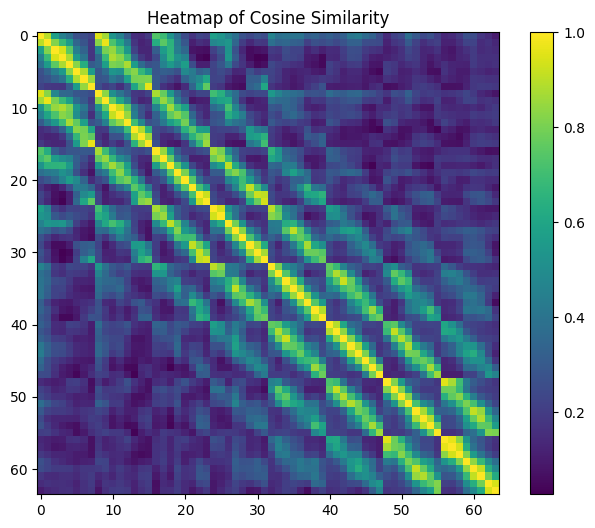

In [4]:
n_values = torch.arange(64).to(device)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [7]:
a.shape, embeddings.shape

(torch.Size([64, 256]), (64, 128))

In [39]:
def generate_sinusoidal_embeddings(num_agents, dimensions):
    position = np.arange(num_agents)[:, np.newaxis]
    div_term = np.exp(np.arange(0, dimensions, 2) * -(np.log(10000.0) / dimensions))
    embeddings = np.zeros((num_agents, dimensions))
    embeddings[:, 0::2] = np.sin(position * div_term)
    embeddings[:, 1::2] = np.cos(position * div_term)
    return embeddings

from sklearn.metrics.pairwise import cosine_similarity
# Generate embeddings
embed1 = generate_sinusoidal_embeddings(64, 256)
embed2 = a.detach().cpu().numpy()
embed2 = embed2 / np.linalg.norm(embed2, axis=1, keepdims=True)
embed1 = torch.tensor(embed1)
embed2 = torch.tensor(embed2)
cos_sim_matrix1 = torch.zeros(64, 64)
cos_sim_matrix2 = torch.zeros(64, 64)
for i in range(64):
    for j in range(64):
        cos_sim_matrix1[i, j] = cos_sim(embed1[i], embed1[j])
        cos_sim_matrix2[i, j] = cos_sim(embed2[i], embed2[j])

# # Plotting the heatmap
# plt.figure(figsize=(12, 8))
# plt.imshow(embeddings, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()
# plt.figure(figsize=(12, 8))
# plt.imshow(embed2, aspect='auto', cmap='viridis')
# plt.colorbar(label='Embedding Value')
# plt.title('Sinusoidal Position Embeddings Heatmap')
# plt.xlabel('Embedding Dimensions')
# plt.ylabel('Agent Index')
# plt.show()

import seaborn as sns

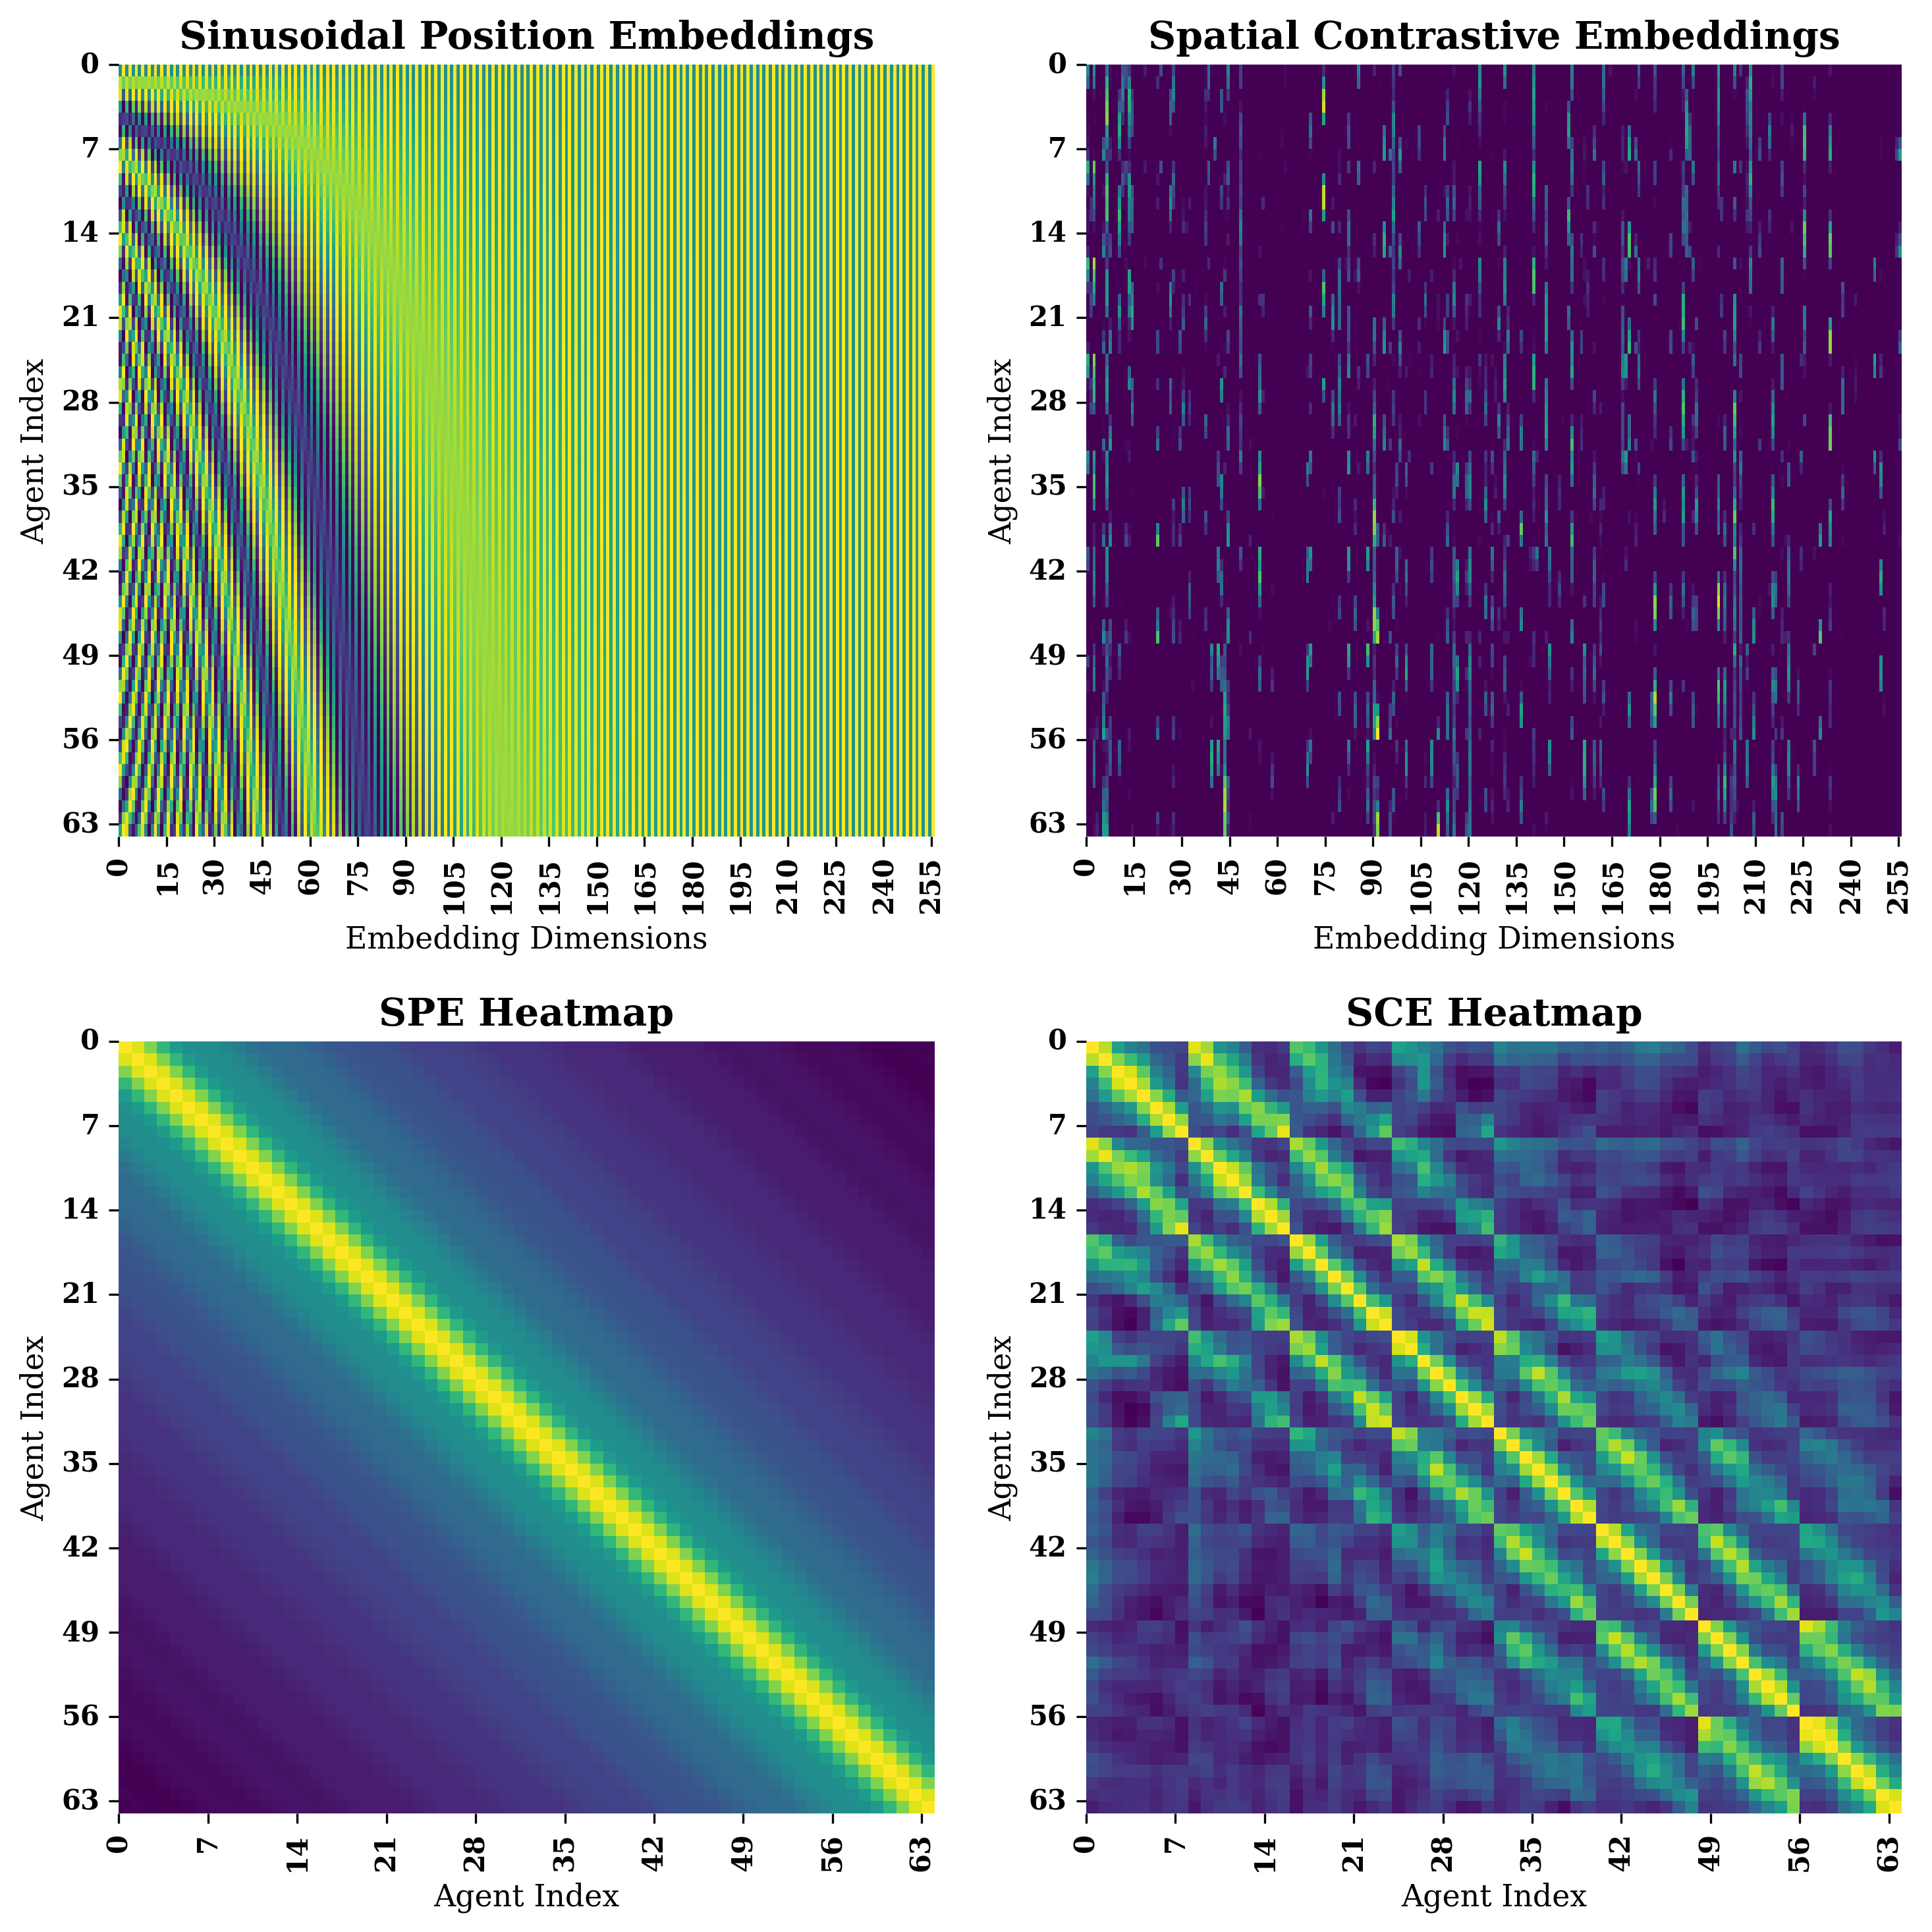

In [53]:

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
font = {'size': 14}
plt.rc('font', **font)
plt.rc('axes', titlesize=font['size'])
plt.rc('legend', fontsize=10)
plt.rc('figure', dpi=300)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

sns.heatmap(embed1, ax=axes[0, 0], cmap="viridis", cbar=False)
axes[0, 0].set_title('Sinusoidal Position Embeddings')
axes[0, 0].set_xlabel('Embedding Dimensions')
axes[0, 0].set_ylabel('Agent Index')
axes[0, 0].set_yticks(np.arange(0, 64, 7))
axes[0, 0].set_yticklabels(np.arange(0, 64, 7))
axes[0, 0].set_xticks(np.arange(0, 256, 15))
axes[0, 0].set_xticklabels(np.arange(0, 256, 15))

sns.heatmap(embed2, ax=axes[0, 1], cmap="viridis", cbar=False)
axes[0, 1].set_title('Spatial Contrastive Embeddings')
axes[0, 1].set_xlabel('Embedding Dimensions')
axes[0, 1].set_ylabel('Agent Index')
axes[0, 1].set_yticks(np.arange(0, 64, 7))
axes[0, 1].set_yticklabels(np.arange(0, 64, 7))
axes[0, 1].set_xticks(np.arange(0, 256, 15))
axes[0, 1].set_xticklabels(np.arange(0, 256, 15))

sns.heatmap(cos_sim_matrix1, ax=axes[1, 0], cmap="viridis", cbar=False)
axes[1, 0].set_title('SPE Heatmap')
axes[1, 0].set_xlabel('Agent Index')
axes[1, 0].set_ylabel('Agent Index')
axes[1, 0].set_yticks(np.arange(0, 64, 7))
axes[1, 0].set_yticklabels(np.arange(0, 64, 7))
axes[1, 0].set_xticks(np.arange(0, 64, 7))
axes[1, 0].set_xticklabels(np.arange(0, 64, 7))

sns.heatmap(cos_sim_matrix2, ax=axes[1, 1], cmap="viridis", cbar=False)
axes[1, 1].set_title('SCE Heatmap')
axes[1, 1].set_xlabel('Agent Index')
axes[1, 1].set_ylabel('Agent Index')
axes[1, 1].set_yticks(np.arange(0, 64, 7))
axes[1, 1].set_yticklabels(np.arange(0, 64, 7))
axes[1, 1].set_xticks(np.arange(0, 64, 7))
axes[1, 1].set_xticklabels(np.arange(0, 64, 7))

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of seaborn color maps
cmaps = [
    'viridis', 'plasma', 'inferno', 'magma', 'cividis', 
    'rocket', 'mako', 'flare', 'crest'
]

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot each color map
fig, axes = plt.subplots(nrows=len(cmaps), figsize=(8, 20))
for ax, cmap in zip(axes, cmaps):
    ax.imshow(gradient, aspect='auto', cmap=sns.color_palette(cmap, as_cmap=True))
    ax.set_title(cmap, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [61]:
# torch.save(model.state_dict(), 'idx_embedding_new.pth')

In [39]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

torch.Size([32, 10, 128])

In [12]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [13]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


TypeError: index_select() received an invalid combination of arguments - got (module, int, Tensor), but expected one of:
 * (Tensor input, int dim, Tensor index, *, Tensor out)
 * (Tensor input, name dim, Tensor index, *, Tensor out)
